In [1]:
modelLoads= ["AA", "AB", "BA", "BB", "infer2018"]
modelLoads1= ["BA"]
modelLoads2= ["BA", "AB", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "GEO"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
commands1=set()
commands2=set()
linuxThread= 3

In [1]:


#experiment1
for modelLoad in ["AB", "BB", "infer2018"]:
    for randomGraph in randomGraphs:
        for seed in seeds:
            for strain in [3, 4]:
                command= f"python run.py --epoches {100000} --modelLoad {modelLoad} --weightModel identical --randomGraph {randomGraph} --seed {seed} --strains {strain}"
                commands1.add(command)
#experiment2
# for strain in strains:
#     for randomGraph in randomGraphs:
#         for seed in seeds:
#             command= f"python run.py --epoches {100000} --modelLoad AA --weightModel identical --randomGraph {randomGraph} --seed {seed} --strains {strain}"
#             commands2.add(command)
# commands2= commands2- commands1

# count=0
# with open("myCommands.bat", 'w') as file:
#     # Write each element on a new line
#     for i, string in enumerate(commands1):
#         file.write(f"echo \"{string} --CMDprogress_{i}_{len(commands1)-1}\"\n")
#         file.write(f"{string} --CMDprogress_{i}_{len(commands1)-1}\n")
        
# count=0
# with open("myCommands.sh", 'w') as file:
#     # Write each element on a new line
#     for i, string in enumerate(commands1):
#         file.write(f"echo \"{string} --CMDprogress_{i}_{len(commands1)-1}\"\n")
#         file.write(f"{string} --CMDprogress_{i}_{len(commands1)-1} &\n")
#         count+=1
#         if count%linuxThread==0:
#             file.write("wait\n")
        

In [2]:
import numpy as np
import torch
import modules.evaluate as evaluate

def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix


IMatrix= torch.eye(50, device= "cpu")

#table one

for modelLoad in modelLoads:
    for randomGraph in randomGraphs:
        print(f"{modelLoad}/{randomGraph}")
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_1_0_100000.npz"
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int((torch.sum(Aw)-0.025)/0.01)
            
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        print(f"{cosines} {spectrals} {edges} {jaccards}")

            

AA/ER
0.5816113352775574 0.5133142471313477 0.49397873878479004 0.328083872795105
AA/BA
0.6079884767532349 0.5968309640884399 0.5546592473983765 0.3839832842350006
AA/WS
0.5873233079910278 0.5924338698387146 0.5211334228515625 0.35260045528411865
AA/GEO
0.6690457463264465 0.8211405873298645 0.6989060640335083 0.5379270911216736
AB/ER
0.545007586479187 0.5869702696800232 0.3756788671016693 0.23139145970344543
AB/BA
0.5068904757499695 0.6222760081291199 0.3432545065879822 0.20727691054344177
AB/WS
0.5380186438560486 0.5719135403633118 0.3721369802951813 0.22861063480377197
AB/GEO
0.591738224029541 0.6915563344955444 0.4243857264518738 0.27033501863479614
BA/ER
0.25320225954055786 0.5427526831626892 0.3586776852607727 0.21858015656471252
BA/BA
0.28519511222839355 0.5324426889419556 0.3571627140045166 0.21744342148303986
BA/WS
0.20877201855182648 0.40288639068603516 0.3756788372993469 0.23142552375793457
BA/GEO
0.3560522198677063 0.8654526472091675 0.46653443574905396 0.3045082986354828
BB

In [3]:
#table one

for randomGraph in randomGraphs:
    for strain in [4]:
        print(f"{strain}_{randomGraph}")
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_4_0_100000.npz"
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int((torch.sum(Aw)-0.025)/0.01)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        print(f"{cosines} {spectrals} {edges} {jaccards}")


4_ER
0.7147125005722046 0.46354570984840393 0.6517119407653809 0.48364514112472534
4_BA
0.7321985363960266 0.5597954392433167 0.690681517124176 0.5277789831161499
4_WS
0.7410200834274292 0.7143431901931763 0.7083824872970581 0.5491231679916382
4_GEO
0.8967057466506958 0.9413869976997375 0.9305208921432495 0.8708680868148804


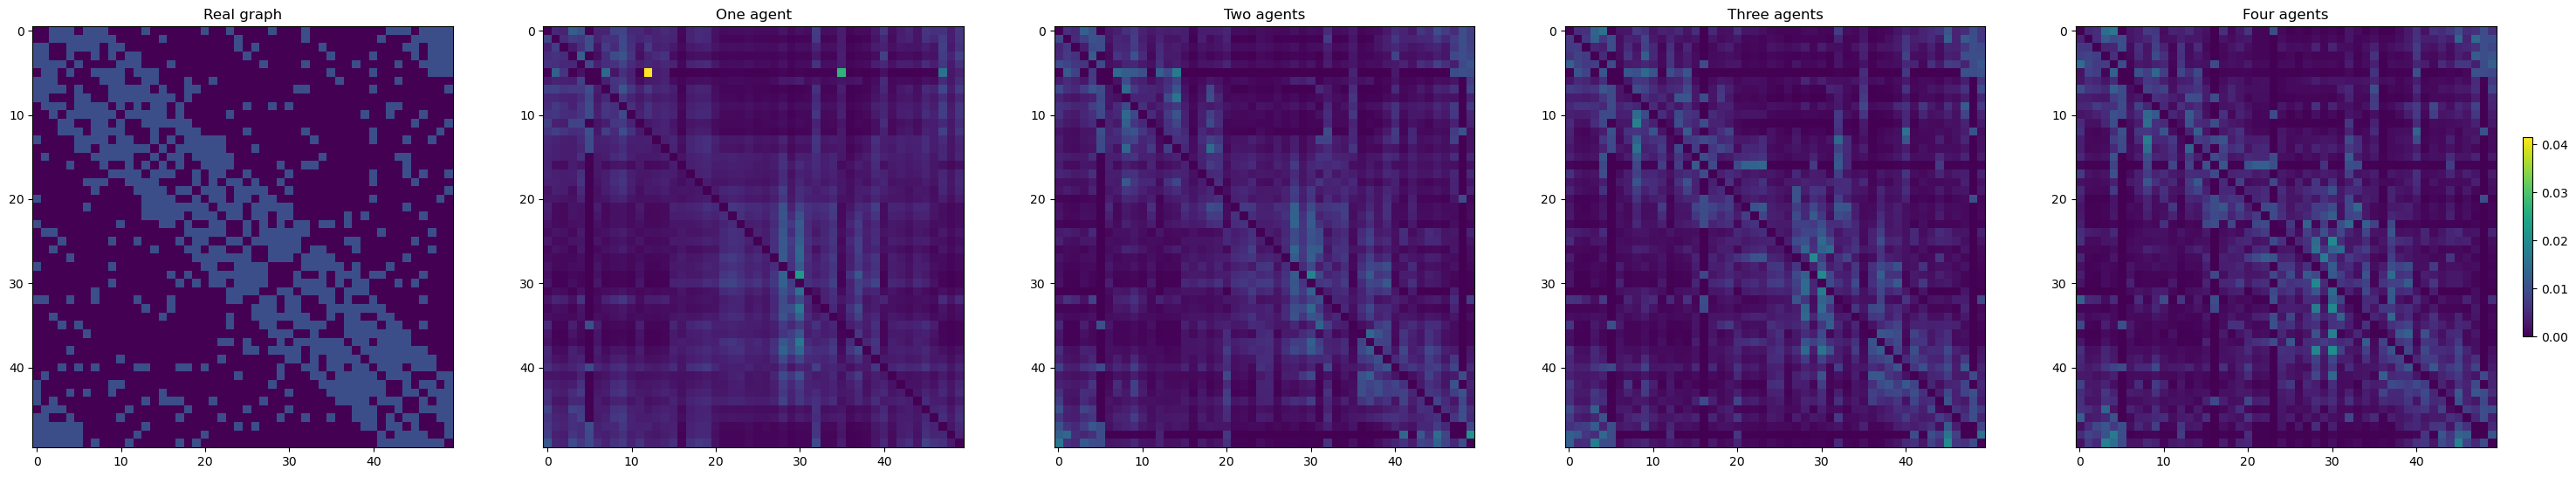

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import modules.plotGraph as plotGraph
import networkx as nx
from matplotlib.colors import Normalize

IMatrixNp= np.eye(50)

maxValue= 0
def load_npz_matrix(fileName, maxValue):
    npzfile = np.load(fileName)
    # Access the arrays in the NPZ file
    Aw = npzfile['A']
    PreA = npzfile['Apre']
    tempMax= np.max(PreA)
    if maxValue<tempMax:
        maxValue=tempMax
    return Aw, PreA, maxValue

PreAs= []
Aw= None
for i in range(4):
    fileName= f"results/AA/AA_WS_identical_11_{i+1}_0_100000.npz"
    Aw, PreA, maxValue= load_npz_matrix(fileName, maxValue)
    PreAs.append(PreA)

campThis= "viridis"

plt.figure(figsize=(30, 6))
# Set up a subplot with 1 row and 2 columns
plt.subplot(1, 5, 1)
plt.imshow(Aw, cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Real graph')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 2)
plt.imshow(PreAs[0], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('One agent')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 3)
plt.imshow(PreAs[1], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Two agents')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 4)
plt.imshow(PreAs[2], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Three agents')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 5)
plt.imshow(PreAs[3], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Four agents')

plt.colorbar(label='',  shrink=0.4)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

797


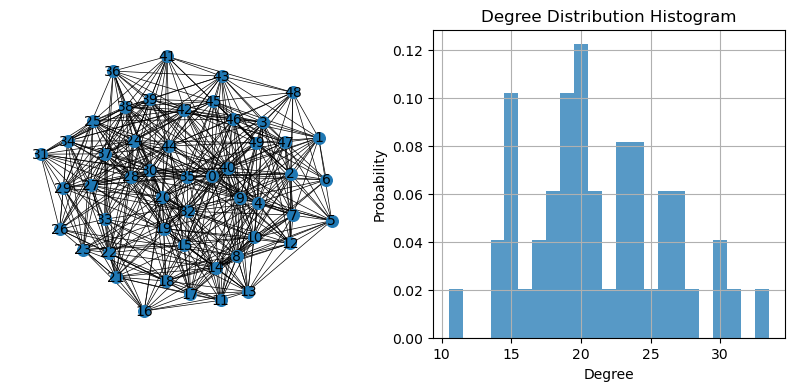

In [42]:
links= int((np.sum(Aw)-0.025)/0.01)
print(links)

PreAsp= continious_to_sparcity(PreAs[3], links)
graphPreA = nx.from_numpy_matrix(PreAsp)

plotGraph.plot_spring_layout(graphPreA)

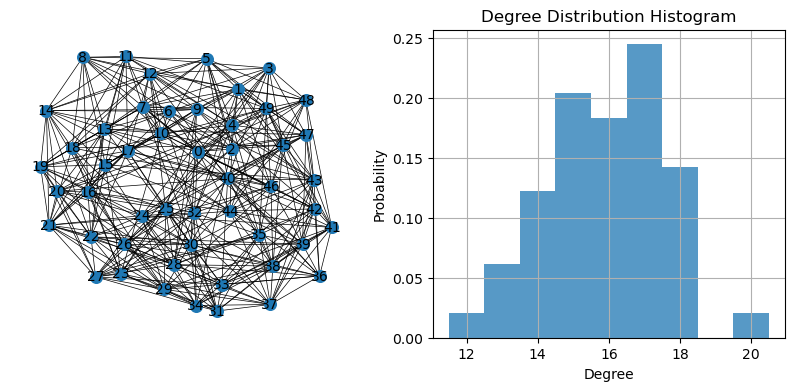

In [43]:
As= continious_to_sparcity(Aw, links)
graphA = nx.from_numpy_matrix(As)

plotGraph.plot_spring_layout(graphA)